This notebook trains multitask models that learn to classify humor in a binary manner, predict how humorous text is, predict whether a humorous text is controversial, and predict how offensive text is- all simultaneously.

First, we load several libraries and import some data.

In [1]:
!pip install transformers

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, mean_squared_error, accuracy_score
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, AutoModel, AdamW, get_linear_schedule_with_warmup, pipeline
import torch
import pandas as pd
import argparse
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle

# sentiment = pipeline("sentiment-analysis")

We use Google Drive for storing/retrieving data files, so they must be in the appropriate file structure within Drive for this code to work.

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Here we define a dataset class for the multitask version of the competition.

In [5]:
class HahaDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, humor_labels, humor_ratings, humor_controversy, off_ratings):
        self.encodings = encodings
        self.humor_labels = humor_labels
        self.humor_ratings = humor_ratings
        self.humor_controversy = humor_controversy
        self.off_ratings = off_ratings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['humor_labels'] = torch.tensor(self.humor_labels[idx])
        item['humor_ratings'] = torch.tensor(self.humor_ratings[idx])
        item['humor_controversy'] = torch.tensor(self.humor_controversy[idx])
        item['off_ratings'] = torch.tensor(self.off_ratings[idx])
        
        return item

    def __len__(self):
        return len(self.humor_labels)


Load the competition data and compute some simple statistics and baselines.

num examples: 8000
num humor: 4932 num not humor: 3068
humor label majority class f1: 0.7627590473244664 humor label majority class accuracy: 0.6165
num examples with humor controversy: 4932
num controversial: 2465 num not controversial: 2467
humor controversy majority class f1: 0.0 humor controversy majority class accuracy: 0.5002027575020276
num examples with humor ratings: 4932
humor ratings -- min: 0.1 median: 2.28 mean: 2.2605251419302514 max: 4.0
humor ratings mean rmse: 0.5669164577335435 humor ratings median rmse: 0.567250861741069


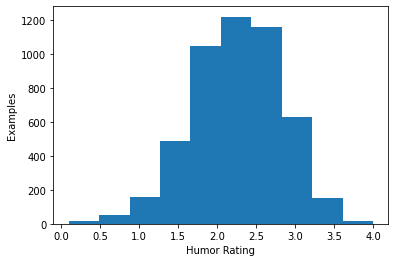

humor ratings (controversial) -- min: 0.45 median: 2.37 mean: 2.3590101419878295 max: 3.68


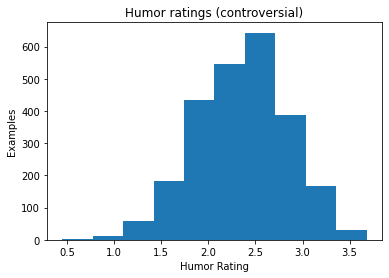

humor ratings (not controversial) -- min: 0.1 median: 2.15 mean: 2.1621199837859746 max: 4.0


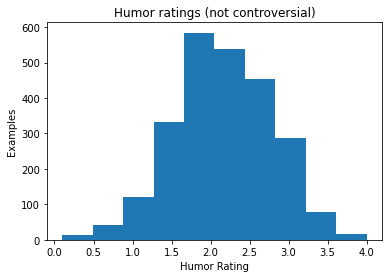

off ratings -- min: 0.0 median: 0.1 mean: 0.5853250000000001 max: 4.85
off ratings mean rmse: 0.9798939454731823 off ratings median rmse: 1.0934955418290466


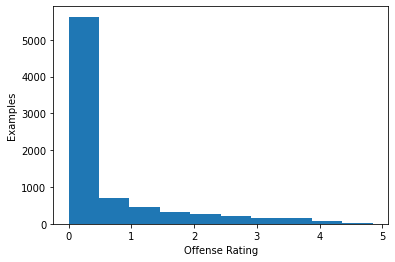

off ratings (humorous) -- min: 0.0 median: 0.35 mean: 0.8987226277372263 max: 4.85


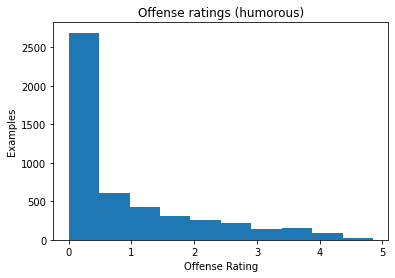

off ratings (not humorous) -- min: 0.0 median: 0.0 mean: 0.08151890482398957 max: 3.65


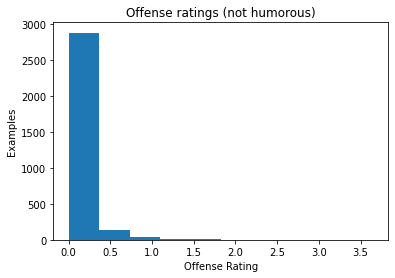

In [7]:
hahackathon_file = "/content/drive/My Drive/Hahackathon/train.csv"
hahackathon_df = pd.read_csv(hahackathon_file, encoding="utf-8")

hahackathon_texts = list(hahackathon_df["text"])
hahackathon_off_ratings = list(hahackathon_df["offense_rating"])
hahackathon_humor_labels = list(hahackathon_df["is_humor"])
hahackathon_humor_ratings = list(hahackathon_df["humor_rating"].fillna(value=-1))
hahackathon_controversy_labels = list(hahackathon_df["humor_controversy"].fillna(value=-1))

num_total = len(hahackathon_humor_labels)
print("num examples:", num_total)
num_humorous = np.sum(np.array(hahackathon_humor_labels) == 1)
print("num humor:", num_humorous, "num not humor:", num_total - num_humorous)
majority_class_humor = np.max([num_humorous, num_total - num_humorous]) / num_total
majority_class_humor_f1 = f1_score(np.array(hahackathon_humor_labels), np.ones(num_total))#, labels=[0,1], average='macro')
print("humor label majority class f1:", majority_class_humor_f1, "humor label majority class accuracy:", majority_class_humor)

humor_controversy_minus_nan = np.array(hahackathon_controversy_labels)
humor_controversy_minus_nan = humor_controversy_minus_nan[humor_controversy_minus_nan != -1]
print("num examples with humor controversy:", len(humor_controversy_minus_nan))
num_controversial = np.sum(humor_controversy_minus_nan == 1)
print("num controversial:", num_controversial, "num not controversial:", len(humor_controversy_minus_nan) - num_controversial)
majority_class_controversial = np.max([num_controversial, len(humor_controversy_minus_nan) - num_controversial]) / len(humor_controversy_minus_nan)
majority_class_controversial_f1 = f1_score(np.array(humor_controversy_minus_nan), np.zeros(len(humor_controversy_minus_nan)))#, labels=[0,1], average='macro')
print("humor controversy majority class f1:", majority_class_controversial_f1, "humor controversy majority class accuracy:", majority_class_controversial)

humor_ratings_minus_nan = np.array(hahackathon_humor_ratings)
humor_ratings_minus_nan = humor_ratings_minus_nan[humor_ratings_minus_nan != -1]
print("num examples with humor ratings:", len(humor_ratings_minus_nan))
print("humor ratings -- min:", np.min(humor_ratings_minus_nan), "median:", np.median(humor_ratings_minus_nan), "mean:", np.mean(humor_ratings_minus_nan), "max:", np.max(humor_ratings_minus_nan))
humor_ratings_mean_rmse = mean_squared_error(humor_ratings_minus_nan, np.ones_like(humor_ratings_minus_nan) * np.mean(humor_ratings_minus_nan), squared=False)
humor_ratings_median_rmse = mean_squared_error(humor_ratings_minus_nan, np.ones_like(humor_ratings_minus_nan) * np.median(humor_ratings_minus_nan), squared=False)
print("humor ratings mean rmse:", humor_ratings_mean_rmse, "humor ratings median rmse:", humor_ratings_median_rmse)

plt.hist(humor_ratings_minus_nan, bins = 10)
plt.xlabel("Humor Rating")
plt.ylabel("Examples")
plt.show()

humor_controversial = humor_ratings_minus_nan[humor_controversy_minus_nan == 1]
print("humor ratings (controversial) -- min:", np.min(humor_controversial), "median:", np.median(humor_controversial), "mean:", np.mean(humor_controversial), "max:", np.max(humor_controversial))

plt.hist(humor_controversial, bins = 10)
plt.title("Humor ratings (controversial)")
plt.xlabel("Humor Rating")
plt.ylabel("Examples")
plt.show()

humor_not_controversial = humor_ratings_minus_nan[humor_controversy_minus_nan == 0]
print("humor ratings (not controversial) -- min:", np.min(humor_not_controversial), "median:", np.median(humor_not_controversial), "mean:", np.mean(humor_not_controversial), "max:", np.max(humor_not_controversial))

plt.hist(humor_not_controversial, bins = 10)
plt.title("Humor ratings (not controversial)")
plt.xlabel("Humor Rating")
plt.ylabel("Examples")
plt.show()

print("off ratings -- min:", np.min(hahackathon_off_ratings), "median:", np.median(hahackathon_off_ratings), "mean:", np.mean(hahackathon_off_ratings), "max:", np.max(hahackathon_off_ratings))
off_ratings_mean_rmse = mean_squared_error(hahackathon_off_ratings, np.ones_like(hahackathon_off_ratings) * np.mean(hahackathon_off_ratings), squared=False)
off_ratings_median_rmse = mean_squared_error(hahackathon_off_ratings, np.ones_like(hahackathon_off_ratings) * np.median(hahackathon_off_ratings), squared=False)
print("off ratings mean rmse:", off_ratings_mean_rmse, "off ratings median rmse:", off_ratings_median_rmse)

plt.hist(hahackathon_off_ratings, bins = 10)
plt.xlabel("Offense Rating")
plt.ylabel("Examples")
plt.show()

off_humorous = np.array(hahackathon_off_ratings)[np.array(hahackathon_humor_labels) == 1]
print("off ratings (humorous) -- min:", np.min(off_humorous), "median:", np.median(off_humorous), "mean:", np.mean(off_humorous), "max:", np.max(off_humorous))

plt.hist(off_humorous, bins = 10)
plt.title("Offense ratings (humorous)")
plt.xlabel("Offense Rating")
plt.ylabel("Examples")
plt.show()

off_not_humorous = np.array(hahackathon_off_ratings)[np.array(hahackathon_humor_labels) == 0]
print("off ratings (not humorous) -- min:", np.min(off_not_humorous), "median:", np.median(off_not_humorous), "mean:", np.mean(off_not_humorous), "max:", np.max(off_not_humorous))

plt.hist(off_not_humorous, bins = 10)
plt.title("Offense ratings (not humorous)")
plt.xlabel("Offense Rating")
plt.ylabel("Examples")
plt.show()

Next, load the Huggingface tokenizer based on the model that we want to run, usually DistilBERT for fast iteration.

In [8]:
print("loading pretrained tokenizer...", flush=True)
model_name = 'distilbert-base-uncased'
# model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)


loading pretrained tokenizer...


Set the hyperparameters.

In [9]:
BATCH_SIZE = 10
EFFECTIVE_BATCH_SIZE = BATCH_SIZE
LEARNING_RATE = 5e-5
NUM_EPOCHS = 3
num_warmup_steps = 500
weight_decay = 0.01

batches_in_effective_batch = int(EFFECTIVE_BATCH_SIZE / BATCH_SIZE)

Load data partitions and create the internal train and validation datasets using our custom Pytorch dataset class.

pad token id: 0


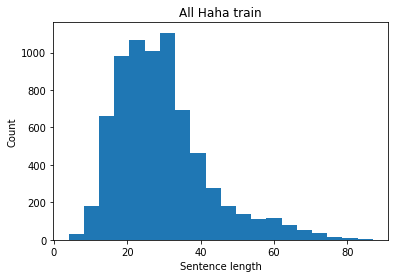

Haha train sent lengths min: 4 mean: 29.400555555555556 median: 27.0 max: 87


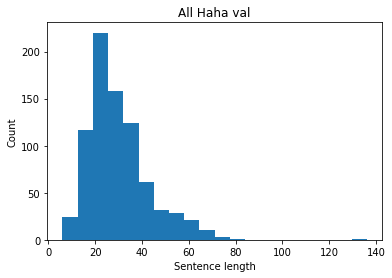

Haha train sent lengths min: 6 mean: 29.645 median: 27.0 max: 136
train size: 7200 val size: 800


In [10]:
hahackathon_train_file = "/content/drive/My Drive/Hahackathon/internal_split/train_90.csv"
hahackathon_train_df = pd.read_csv(hahackathon_train_file, encoding="utf-8")

haha_train_texts = list(hahackathon_train_df["text"])
haha_train_off_ratings = list(hahackathon_train_df["offense_rating"])
haha_train_humor_labels = list(hahackathon_train_df["is_humor"])
haha_train_humor_ratings = list(hahackathon_train_df["humor_rating"].fillna(value=-1))
haha_train_humor_controversy = list(hahackathon_train_df["humor_controversy"].fillna(value=-1))
haha_train_encodings = tokenizer(haha_train_texts, truncation=True, padding=True)

print("pad token id:", tokenizer.pad_token_id)

haha_train_sent_lengths = np.sum(np.array(haha_train_encodings['input_ids']) != tokenizer.pad_token_id, axis=1)
plt.hist(haha_train_sent_lengths, bins=20)
plt.xlabel("Sentence length")
plt.ylabel("Count")
plt.title("All Haha train")
plt.show()
print("Haha train sent lengths min:", np.min(haha_train_sent_lengths), "mean:", np.mean(haha_train_sent_lengths), "median:", np.median(haha_train_sent_lengths), "max:", np.max(haha_train_sent_lengths))

hahackathon_val_file = "/content/drive/My Drive/Hahackathon/internal_split/test_10.csv"
hahackathon_val_df = pd.read_csv(hahackathon_val_file, encoding="utf-8")

haha_val_texts = list(hahackathon_val_df["text"])
haha_val_off_ratings = list(hahackathon_val_df["offense_rating"])
haha_val_humor_labels = list(hahackathon_val_df["is_humor"])
haha_val_humor_ratings = list(hahackathon_val_df["humor_rating"].fillna(value=-1))
haha_val_humor_controversy = list(hahackathon_val_df["humor_controversy"].fillna(value=-1))
haha_val_encodings = tokenizer(haha_val_texts, truncation=True, padding=True)

haha_val_sent_lengths = np.sum(np.array(haha_val_encodings['input_ids']) != tokenizer.pad_token_id, axis=1)
plt.hist(haha_val_sent_lengths, bins=20)
plt.xlabel("Sentence length")
plt.ylabel("Count")
plt.title("All Haha val")
plt.show()
print("Haha train sent lengths min:", np.min(haha_val_sent_lengths), "mean:", np.mean(haha_val_sent_lengths), "median:", np.median(haha_val_sent_lengths), "max:", np.max(haha_val_sent_lengths))

haha_train_dataset = HahaDataset(haha_train_encodings, haha_train_humor_labels, haha_train_humor_ratings, haha_train_humor_controversy, haha_train_off_ratings)
haha_train_loader = DataLoader(haha_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
haha_val_dataset = HahaDataset(haha_val_encodings, haha_val_humor_labels, haha_val_humor_ratings, haha_val_humor_controversy, haha_val_off_ratings)
haha_val_loader = DataLoader(haha_val_dataset, batch_size=BATCH_SIZE)

print("train size:", len(haha_train_dataset), "val size:", len(haha_val_dataset))


Define a function that consumes a batch from our custom dataset object and retrieves predictions and losses associated with each task and its respective prediction head. Also define a function that produces metrics based on a validation set.

In [11]:
def process_batch(model, batch, loss_reduce='mean'):
    input_ids = batch['input_ids'].to(device)
    sent_len = torch.sum(input_ids != tokenizer.pad_token_id, dim=1)
    # print(sent_len)
    attention_mask = batch['attention_mask'].to(device)

    humor_labels = batch['humor_labels'].long().to(device)
    humor_ratings = batch['humor_ratings'].float().to(device)
    humor_controversy = batch['humor_controversy'].long().to(device)
    off_ratings = batch['off_ratings'].float().to(device)

    distilbert_output = model(input_ids, attention_mask=attention_mask)
    hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
    pooled_output = hidden_state[:, 0]  # (bs, dim)

    pre_humor = F.relu(model.pre_humor(pooled_output))
    humor_logits = model.humor_head(model.dropout(pre_humor))
    humor_rating_logits = model.humor_rating_head(model.dropout(F.relu(model.pre_humor_rating(pooled_output))))
    # humor_rating_logits = model.humor_rating_head(model.dropout(F.relu(model.pre_humor_rating(pre_humor))))
    humor_controversy_logits = model.humor_controversy_head(model.dropout(F.relu(model.pre_humor_controversy(pooled_output))))
    # humor_controversy_logits = model.humor_controversy_head(model.dropout(F.relu(model.pre_humor_controversy(pre_humor))))
    off_logits = model.off_head(model.dropout(F.relu(model.pre_off(pooled_output))))
    # off_logits = model.off_head(model.dropout(F.relu(model.pre_off(pre_humor))))

    return_objects = {}
    return_objects["sent_len"] = sent_len
    
    class_loss_fn = torch.nn.CrossEntropyLoss(reduction=loss_reduce)
    regression_loss_fn = torch.nn.MSELoss(reduction=loss_reduce)

    humor_mask = humor_labels != -1
    return_objects["humor_loss"] = class_loss_fn(humor_logits[humor_mask], humor_labels[humor_mask])
    humor_rating_mask = humor_ratings != -1
    return_objects["humor_rating_loss"] = regression_loss_fn(humor_rating_logits[humor_rating_mask].view(-1), humor_ratings[humor_rating_mask])
    humor_controversy_mask = humor_controversy != -1
    return_objects["humor_controversy_loss"] = class_loss_fn(humor_controversy_logits[humor_controversy_mask], humor_controversy[humor_controversy_mask])
    off_mask = off_ratings != -1
    return_objects["off_loss"] = regression_loss_fn(off_logits[off_mask].view(-1), off_ratings[off_mask])

    return_objects["humor_logits"] = humor_logits[humor_mask]
    return_objects["humor_rating_logits"] = humor_rating_logits[humor_rating_mask]
    return_objects["humor_controversy_logits"] = humor_controversy_logits[humor_controversy_mask]
    return_objects["off_logits"] = off_logits[off_mask]

    return_objects["humor_labels"] = humor_labels[humor_mask]
    return_objects["humor_ratings"] = humor_ratings[humor_rating_mask]
    return_objects["humor_controversy"] = humor_controversy[humor_controversy_mask]
    return_objects["off_ratings"] = off_ratings[off_mask]
    
    return return_objects

def weighted_sum_loss(losses, weights):
    combined_loss = 0.0
    for l_name, l in losses:
        combined_loss += l * weights[l_name]
    return combined_loss

def evaluate(model, batch_loader):
    model.eval()
    return_metrics = {}
    with torch.no_grad():
        all_return_objects = None
        for batch in batch_loader:
            return_objects = process_batch(model, batch, loss_reduce='none')

            if all_return_objects is None:
                all_return_objects = return_objects
            else:
                for key in all_return_objects:
                    all_return_objects[key] = torch.cat((all_return_objects[key], return_objects[key]), dim=0)

        eval_keys = [("humor_labels", "humor", "classification"), ("humor_ratings", "humor_rating", "regression"), 
                     ("humor_controversy", "humor_controversy", "classification"), ("off_ratings", "off", "regression")]

        return_metrics["sent_len"] = all_return_objects["sent_len"]

        for (y_key, out_name, problem_type) in eval_keys:
            if all_return_objects[y_key].size()[0] > 0:
                return_metrics[out_name + "_loss"] = float(all_return_objects[out_name + "_loss"].mean())
                
                if problem_type == "classification":
                    probs = F.softmax(all_return_objects[out_name + "_logits"], dim=1)
                    y_hat = probs.argmax(dim=1)
                    return_metrics[out_name + "_predictions"] = probs.cpu()
                    return_metrics[out_name + "_labels"] = all_return_objects[y_key].cpu()
                    return_metrics[out_name + "_f1"] = f1_score(all_return_objects[y_key].cpu(), y_hat.cpu())#, labels=[0, 1], average='macro')
                    return_metrics[out_name + "_acc"] = accuracy_score(all_return_objects[y_key].cpu(), y_hat.cpu())
                elif problem_type == "regression":
                    return_metrics[out_name + "_predictions"] = torch.clamp(all_return_objects[out_name + "_logits"].view(-1).cpu(), 0.0, 5.0)
                    return_metrics[out_name + "_labels"] = all_return_objects[y_key].cpu()
                    return_metrics[out_name + "_rmse"] = mean_squared_error(all_return_objects[y_key].cpu(), torch.clamp(all_return_objects[out_name + "_logits"].view(-1).cpu(), 0.0, 5.0), squared=False)
                else:
                    raise ValueError(problem_type)
                
            else:
                return_metrics[out_name + "_loss"] = 'n/a'
                
                if problem_type == "classification":
                    return_metrics[out_name + "_f1"] = 'n/a'
                elif problem_type == "regression":
                    return_metrics[out_name + "_rmse"] = 'n/a'
                else:
                    raise ValueError(problem_type)    

    return return_metrics


Define a function for training a model given training and development datasets, using the previously defined hyperparameters.

In [12]:
def train_model(train_loader, val_loader, loss_weights, num_epochs=3, pre_trained_model=None, verbose=False):
    # model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)
    if pre_trained_model is None:
        model = AutoModel.from_pretrained(model_name, config=config)
        model.dropout = torch.nn.Dropout(0.2)
        head_dim = 768
        model.pre_humor = torch.nn.Linear(head_dim, head_dim)
        model.humor_head = torch.nn.Linear(head_dim, config.num_labels)
        model.pre_humor_rating = torch.nn.Linear(head_dim, head_dim)
        model.humor_rating_head = torch.nn.Linear(head_dim, 1)
        model.pre_humor_controversy = torch.nn.Linear(head_dim, head_dim)
        model.humor_controversy_head = torch.nn.Linear(head_dim, config.num_labels)
        model.pre_off = torch.nn.Linear(head_dim, head_dim)
        model.off_head = torch.nn.Linear(head_dim, 1)
    else:
        print("using intermediate finetuning")
        model = pre_trained_model
    model.to(device)
    

    effective_num_batches = int(np.ceil(float(len(train_loader)) / float(batches_in_effective_batch)))
    total_train_steps = num_epochs * effective_num_batches
    print("warmup steps:", num_warmup_steps, "total train steps:", total_train_steps)

    optim = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=weight_decay)
    scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps, total_train_steps)

    print("starting to train...", flush=True)


    optim.zero_grad()
    for epoch in range(num_epochs):
        model.train()
        batch_count = 0
        for batch in train_loader:
            
            all_return_objects = process_batch(model, batch)
            all_losses = [(x, all_return_objects[x]) for x in all_return_objects if "_loss" in x]
            # print(all_losses)
            loss = weighted_sum_loss(all_losses, loss_weights) # [weight_off, weight_humor])
            # print(loss)
            loss.backward()

            batch_count += 1
            if batch_count % batches_in_effective_batch == 0 or batch_count == len(train_loader) - 1:
                optim.step()
                scheduler.step()
                optim.zero_grad()

                if verbose and int(batch_count / batches_in_effective_batch) % int(np.ceil(float(len(train_loader)) / float(batches_in_effective_batch)) / 20.0) == 0:
                    loss_format_str = ", ".join([x + ": " + str(float(all_return_objects[x])) for x in all_return_objects if "_loss" in x])
                    print("batch", int(batch_count / batches_in_effective_batch), "of", int(np.ceil(float(len(train_loader)) / float(batches_in_effective_batch))), ",", "train loss:", float(loss), loss_format_str, flush=True)

        # if partition < len(hahackathon_humor_labels):
        all_metrics = evaluate(model, val_loader)
        all_losses = [(x, all_return_objects[x]) for x in all_metrics if "_loss" in x]
        dev_loss = weighted_sum_loss(all_losses, loss_weights) # [weight_off, weight_humor])
        metric_format_str = ", ".join([x + ": " + str(float(all_metrics[x])) for x in list(sorted(all_metrics.keys())) if "f1" in x or "acc" in x or "rmse" in x])
        print("epoch", epoch, "dev loss:", float(dev_loss), metric_format_str, flush=True)
        # else:
        #     print("epoch", epoch)
            
        # test_loss_off, test_loss_humor, test_f1_off, test_f1_humor = evaluate(model, test_loader)
        # test_loss = weighted_sum_loss([test_loss_off, test_loss_humor], [weight_off, weight_humor])
        # print("test loss:", float(test_loss), "loss off:", float(test_loss_off), "loss humor:", float(test_loss_humor), "test f1 off:", test_f1_off, "test f1 humor:", test_f1_humor, flush=True)

        # hahackathon_loss_off, hahackathon_loss_humor, hahackathon_f1_off, hahackathon_f1_humor = evaluate(model, hahackathon_loader)
        # hahackathon_loss = weighted_sum_loss([hahackathon_loss_off, hahackathon_loss_humor], [weight_off, weight_humor])
        # print("hahackathon loss:", float(hahackathon_loss), "loss off:", float(hahackathon_loss_off), "loss humor:", float(hahackathon_loss_humor), "hahackathon f1 off:", hahackathon_f1_off, "hahackathon f1 humor:", hahackathon_f1_humor, flush=True)    
    return model, all_metrics


Train the model for 5 random restarts.

In [13]:
loss_weights = {}
loss_weights["humor_loss"] = 0.0
loss_weights["humor_rating_loss"] = 0.0
loss_weights["humor_controversy_loss"] = 0.0
loss_weights["off_loss"] = 1.0

print("loss weights:", loss_weights)

print("loading pretrained model...", flush=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device, flush=True)

config = AutoConfig.from_pretrained(model_name)
# config.output_hidden_states = True
# config.num_labels = NUM_LABELS

all_restart_metrics = []
all_models = []

RANDOM_RESTARTS = 5
for r in range(RANDOM_RESTARTS):
    print("random restart", r, "------------------------------------------------------")

    model, all_metrics = train_model(haha_train_loader, haha_val_loader, loss_weights, num_epochs=NUM_EPOCHS)
    model.cpu()
    all_models.append(model)
    
    all_restart_metrics.append(all_metrics)

# aggregate metrics from all restarts to get mean and standard deviation
metric_keys = [k for k in list(sorted(all_restart_metrics[0].keys())) if "f1" in k or "acc" in k or "rmse" in k]
metric_vals = {k: [] for k in metric_keys}
for restart in all_restart_metrics:
    for k in metric_keys:
        metric_vals[k].append(restart[k])

print("----------------------------------------------------------------")
for k in metric_keys:
    mean_k = np.mean(metric_vals[k])
    std_k = np.std(metric_vals[k])
    print(k, ":", mean_k, "+/-", std_k)


loss weights: {'humor_loss': 0.0, 'humor_rating_loss': 0.0, 'humor_controversy_loss': 0.0, 'off_loss': 1.0}
loading pretrained model...
cuda
random restart 0 ------------------------------------------------------
warmup steps: 500 total train steps: 2160
starting to train...
epoch 0 dev loss: 0.0696108341217041 humor_acc: 0.54375, humor_controversy_acc: 0.4928131416837782, humor_controversy_f1: 0.6545454545454545, humor_f1: 0.4478063540090772, humor_rating_rmse: 2.32226824760437, off_rmse: 0.617268443107605
epoch 1 dev loss: 0.0904281958937645 humor_acc: 0.45625, humor_controversy_acc: 0.5010266940451745, humor_controversy_f1: 0.667578659370725, humor_f1: 0.21052631578947367, humor_rating_rmse: 2.3222522735595703, off_rmse: 0.6147935390472412
epoch 2 dev loss: 0.2772137224674225 humor_acc: 0.45875, humor_controversy_acc: 0.49691991786447637, humor_controversy_f1: 0.6639231824417009, humor_f1: 0.21415607985480942, humor_rating_rmse: 2.322152853012085, off_rmse: 0.5657570362091064
random

Ensemble the 5 random restarts together.

ensemble by average --------------------------------------------------
humor f1: 0.17677642980935873 acc: 0.40625


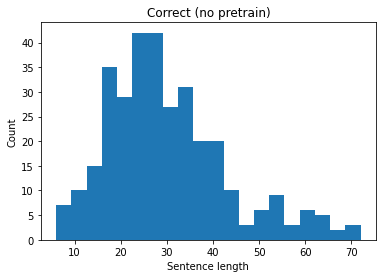

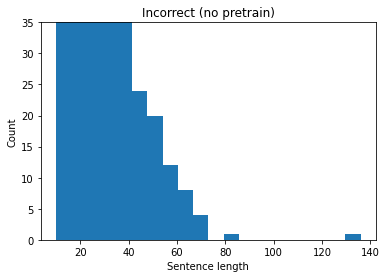

no_pretrain correct sent length -- min: 6 mean: 30.006153846153847 median: 28.0 max: 72
no pretrain incorrect sent length -- min: 10 mean: 29.397894736842105 median: 27.0 max: 136
humor_rating rmse: 2.2917149100041403
humor_controversy f1: 0.5747126436781609 acc: 0.4681724845995893
off rmse: 0.5435247656013068
ensemble by majority vote (classification only) ----------------------
humor f1: 0.19332161687170477 acc: 0.42625
humor_controversy f1: 0.5519713261648745 acc: 0.486652977412731


In [14]:
save_path = "/content/drive/My Drive/Hahackathon/" + model_name + "_predictions_"

# try ensembling them together
ensemble_labels = {k: all_restart_metrics[0][k] for k in all_restart_metrics[0] if "labels" in k}
prediction_keys = [k for k in all_restart_metrics[0] if "predictions" in k]
sent_lengths = all_restart_metrics[0]["sent_len"].cpu()
prediction_vals = {k: [] for k in prediction_keys}

# average predictions together
for restart in all_restart_metrics:
    for k in prediction_keys:
        prediction_vals[k].append(restart[k].tolist())

print("ensemble by average --------------------------------------------------")
for k in prediction_keys:
    out_name = k.rsplit("_", 1)[0]
    mean_preds = np.mean(prediction_vals[k], axis=0)
    if "rating" in k or "off" in k:
        np.save(save_path + out_name + ".npy", mean_preds)
        rmse = mean_squared_error(ensemble_labels[out_name + "_labels"], mean_preds, squared=False)
        print(out_name, "rmse:", rmse)
    else:
        y_hat = np.argmax(mean_preds, axis=1)
        y_true = ensemble_labels[out_name + "_labels"].numpy()
        f1 = f1_score(y_true, y_hat)#, labels=[0, 1], average='macro')
        acc = accuracy_score(y_true, y_hat)
        print(out_name, "f1:", f1, "acc:", acc)

        np.save(save_path + out_name + ".npy", mean_preds)

        # print(y_hat == y_true)
        if k == "humor_predictions":
            sent_correct = y_hat == y_true
            sent_len_correct = sent_lengths[sent_correct].numpy()
            plt.hist(sent_len_correct, bins=20)
            plt.xlabel("Sentence length")
            plt.ylabel("Count")
            plt.title("Correct (no pretrain)")
            plt.show()

            sent_incorrect = y_hat != y_true
            sent_len_incorrect = sent_lengths[sent_incorrect].numpy()
            plt.hist(sent_len_incorrect, bins=20)
            plt.xlabel("Sentence length")
            plt.ylabel("Count")
            plt.title("Incorrect (no pretrain)")
            plt.ylim(0, 35)
            plt.show()

            print("no_pretrain correct sent length -- min:", np.min(sent_len_correct), "mean:", np.mean(sent_len_correct), "median:", np.median(sent_len_correct), "max:", np.max(sent_len_correct))
            print("no pretrain incorrect sent length -- min:", np.min(sent_len_incorrect), "mean:", np.mean(sent_len_incorrect), "median:", np.median(sent_len_incorrect), "max:", np.max(sent_len_incorrect))


# get majority votes
vote_vals = {k: [] for k in prediction_keys if "rating" not in k and "off" not in k}
for restart in all_restart_metrics:
    for k in vote_vals:
        vote_vals[k].append(restart[k].argmax(dim=1).tolist())

print("ensemble by majority vote (classification only) ----------------------")
for k in vote_vals:
    out_name = k.rsplit("_", 1)[0]
    mean_preds = np.mean(vote_vals[k], axis=0)

    y_hat = np.round(mean_preds)
    f1 = f1_score(ensemble_labels[out_name + "_labels"], y_hat)#, labels=[0, 1], average='macro')
    acc = accuracy_score(ensemble_labels[out_name + "_labels"], y_hat)
    print(out_name, "f1:", f1, "acc:", acc)

Define a function to generate predictions to submit to the leaderboard or use for further ensembling (between different pretrained language models) depending on whether the "should_argmax" option is set to True or False.

In [15]:
def generate_predictions(all_models, in_path, out_path, should_argmax=True, cols_to_include=[0, 1, 2, 3]):
    with open(in_path, encoding='utf-8') as in_file:
        df = pd.read_csv(in_path)
    
    ids = list(df["id"])
    texts = list(df["text"])

    all_humor_logits = []
    all_humor_rating_logits = []
    all_controversy_logits = []
    all_off_logits = []


    for model in all_models:
        model.to(device)
        model.eval()

        model_humor_logits = []
        model_humor_rating_logits = []
        model_controversy_logits = []
        model_off_logits = []
        
        for i in range(len(ids)):
            encoding = tokenizer(texts[i], truncation=True, padding=True)
            # print(encoding.size())

            distilbert_output = model(torch.tensor([encoding["input_ids"]], device=device), attention_mask=torch.tensor([encoding["attention_mask"]], device=device))
            hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
            # print(hidden_state.size())
            pooled_output = hidden_state[:, 0]  # (bs, dim)
            # print(pooled_output.size())
            pre_humor = F.relu(model.pre_humor(pooled_output))

            humor_logits = model.humor_head(model.dropout(pre_humor))
            humor_rating = model.humor_rating_head(model.dropout(F.relu(model.pre_humor_rating(pooled_output))))
            humor_controversy_logits = model.humor_controversy_head(model.dropout(F.relu(model.pre_humor_controversy(pooled_output))))
            offense_rating = model.off_head(model.dropout(F.relu(model.pre_off(pooled_output))))

            # print(humor_logits.size())
            humor_label = F.softmax(humor_logits, dim=1) #.argmax(dim=1)
            humor_controversy = F.softmax(humor_controversy_logits, dim=1) #.argmax(dim=1)
            humor_rating = torch.clamp(humor_rating, 0.0, 5.0)
            offense_rating = torch.clamp(offense_rating, 0.0, 5.0)

            model_humor_logits.append(humor_label[0].tolist())
            model_humor_rating_logits.append(float(humor_rating[0][0]))
            model_controversy_logits.append(humor_controversy[0].tolist())
            model_off_logits.append(float(offense_rating[0][0]))

            if i % 100 == 0:
                print(i, "done")

        all_humor_logits.append(model_humor_logits)
        all_humor_rating_logits.append(model_humor_rating_logits)
        all_controversy_logits.append(model_controversy_logits)
        all_off_logits.append(model_off_logits)
        model.cpu()


    mean_humor_logits = np.mean(all_humor_logits, axis=0)
    mean_humor_rating_logits = np.mean(all_humor_rating_logits, axis=0)
    mean_controversy_logits = np.mean(all_controversy_logits, axis=0)
    mean_off_logits = np.mean(all_off_logits, axis=0)

    if should_argmax:
        mean_humor_logits = np.argmax(mean_humor_logits, axis=1)
        mean_controversy_logits = np.argmax(mean_controversy_logits, axis=1)
    else:
        mean_humor_logits = mean_humor_logits[:, 1]
        mean_controversy_logits = mean_controversy_logits[:, 1]

    with open(out_path, "w") as out_file:
        out_file.write("id")
        if 0 in cols_to_include:
            out_file.write(",is_humor")
        if 1 in cols_to_include:
            out_file.write(",humor_rating")
        if 2 in cols_to_include:
            out_file.write(",humor_controversy")
        if 3 in cols_to_include:
            out_file.write(",offense_rating")
        out_file.write("\n")

        for i in range(len(ids)):
            result_strs = [str(ids[i])]
            if 0 in cols_to_include:
                if should_argmax:
                    result_strs.append(str(int(mean_humor_logits[i])))
                else:
                    result_strs.append(str(mean_humor_logits[i]))
            if 1 in cols_to_include:
                result_strs.append(str(mean_humor_rating_logits[i]))
            if 2 in cols_to_include:
                if should_argmax:
                    result_strs.append(str(int(mean_controversy_logits[i])))
                else:
                    result_strs.append(str(mean_controversy_logits[i]))
            if 3 in cols_to_include:
                result_strs.append(str(mean_off_logits[i]))
            format_str = ",".join(result_strs)
            # print(format_str)
            out_file.write(format_str + "\n")

            if i % 100 == 0:
                print(i, "done")

In [16]:
generate_predictions(all_models, "/content/drive/My Drive/Hahackathon/public_dev.csv", "/content/drive/My Drive/Hahackathon/"+model_name+"_offense_individual_out_dev_labels.csv", should_argmax=True, cols_to_include=[3])
# generate_predictions(all_models, "/content/drive/My Drive/Hahackathon/public_dev.csv", "/content/drive/My Drive/Hahackathon/"+model_name+"_out_dev_labels.csv", should_argmax=True)
# generate_predictions(all_models, "/content/drive/My Drive/Hahackathon/public_dev.csv", "/content/drive/My Drive/Hahackathon/"+model_name+"_out_dev_preds.csv", should_argmax=False)

0 done
100 done
200 done
300 done
400 done
500 done
600 done
700 done
800 done
900 done
0 done
100 done
200 done
300 done
400 done
500 done
600 done
700 done
800 done
900 done
0 done
100 done
200 done
300 done
400 done
500 done
600 done
700 done
800 done
900 done
0 done
100 done
200 done
300 done
400 done
500 done
600 done
700 done
800 done
900 done
0 done
100 done
200 done
300 done
400 done
500 done
600 done
700 done
800 done
900 done
0 done
100 done
200 done
300 done
400 done
500 done
600 done
700 done
800 done
900 done


Load the 200k humor dataset and calculate some basic statistics.

In [ ]:
# train_file = "/content/drive/My Drive/OLID/olid-training-v1.0.tsv"
# test_tweets = "/content/drive/My Drive/OLID/testset-levela.tsv"
# test_labels = "/content/drive/My Drive/OLID/labels-levela.csv"

# hatebase_file = "/content/drive/My Drive/Hatebase/labeled_data.csv"

humor200k_train_file = "/content/drive/My Drive/humor_200k/train.csv"
humor200k_dev_file = "/content/drive/My Drive/humor_200k/dev.csv"
humor200k_test_file = "/content/drive/My Drive/humor_200k/test.csv"

# print("reading csvs...", flush=True)

# train_df = pd.read_csv(train_file, sep="\t", encoding="utf-8")
# test_tweets_df = pd.read_csv(test_tweets, sep="\t", encoding="utf-8")
# test_labels_df = pd.read_csv(test_labels, names=["index", "label"], encoding="utf-8")

# hatebase_df = pd.read_csv(hatebase_file)

# print("splitting into train/val...", flush=True)

# train_texts, train_off_labels = list(train_df["tweet"]), train_df["subtask_a"]
# test_texts, test_off_labels = list(test_tweets_df["tweet"]), test_labels_df["label"]

# print("olid training size:", len(train_texts), flush=True)
# print("hatebase training size:", len(hatebase_df["tweet"]), flush=True)

# # print(train_labels, flush=True)
# # print(test_labels, flush=True)

# train_off_labels = list(train_off_labels.replace("OFF", 1).replace("NOT", 0).astype('int32'))
# test_off_labels = list(test_off_labels.replace("OFF", 1).replace("NOT", 0).astype('int32'))

# # print(train_labels, flush=True)
# # print(test_labels, flush=True)

# NUM_LABELS = 2
# train_texts = preprocess_texts(train_texts)
# test_texts = preprocess_texts(test_texts)

# train_texts, val_texts, train_off_labels, val_off_labels = train_test_split(train_texts, train_off_labels, test_size=.2)

# hatebase_labels = list(hatebase_df["class"].replace(0, 1).replace(2, 0))

# train_texts += preprocess_texts(list(hatebase_df["tweet"]))
# train_off_labels += hatebase_labels

# train_humor_labels = list(np.ones(len(train_off_labels)) * -1)
# val_humor_labels = list(np.ones(len(val_off_labels)) * -1)
# test_humor_labels = list(np.ones(len(test_off_labels)) * -1)

# print("offensive only-- train size:", len(train_texts), "val size:", len(val_texts), "test size:", len(test_texts))

humor200k_train_df = pd.read_csv(humor200k_train_file, encoding="utf-8")
humor200k_dev_df = pd.read_csv(humor200k_dev_file, encoding="utf-8")

h200k_train_texts, h200k_train_humor_labels = list(humor200k_train_df["text"]), np.array(humor200k_train_df['humor'].astype(int))
h200k_val_texts, h200k_val_humor_labels = list(humor200k_dev_df["text"]), np.array(humor200k_dev_df['humor'].astype(int))

h200k_train_texts, h200k_val_texts, h200k_train_humor_labels, h200k_val_humor_labels = train_test_split(h200k_train_texts, h200k_train_humor_labels, test_size=.2)

h200k_train_humor_ratings = np.ones(len(h200k_train_humor_labels)) * -1
h200k_train_humor_controversy = np.ones(len(h200k_train_humor_labels)) * -1
h200k_train_off_ratings = np.ones(len(h200k_train_humor_labels)) * -1
h200k_val_humor_ratings = np.ones(len(h200k_val_humor_labels)) * -1
h200k_val_humor_controversy = np.ones(len(h200k_val_humor_labels)) * -1
h200k_val_off_ratings = np.ones(len(h200k_val_humor_labels)) * -1

print("humor only-- train size:", len(h200k_train_texts), "val size:", len(h200k_val_texts))


print("encoding texts with pretrained tokenizer...", flush=True)

h200k_train_encodings = tokenizer(h200k_train_texts, truncation=True, padding=True)
# print(np.array(h200k_train_encodings['input_ids']) != 0)
# h200k_train_sent_lengths = np.sum(np.array(h200k_train_encodings['input_ids']) != tokenizer.pad_token_id, axis=1)
plt.rcParams["figure.figsize"] = (12,5)
plt.subplot(1,2,1)
h200k_train_sent_lengths = [len(t) for j, t in enumerate(h200k_train_texts) if h200k_train_humor_labels[j]]
plt.hist(h200k_train_sent_lengths, bins=20, density=True)
plt.xlabel("Text length")
plt.ylabel("Percent of Samples")
plt.title("200k Humor")
# plt.show()

plt.subplot(1,2,2)
h200k_train_sent_lengths = [len(t) for j, t in enumerate(h200k_train_texts) if not h200k_train_humor_labels[j]]
plt.hist(h200k_train_sent_lengths, bins=20, density=True)
plt.xlabel("Text length")
plt.ylabel("Percent of Samples")
plt.title("200k Non-Humor")
plt.show()

print("h200k sent lengths min:", np.min(h200k_train_sent_lengths), "mean:", np.mean(h200k_train_sent_lengths), "median:", np.median(h200k_train_sent_lengths), "max:", np.max(h200k_train_sent_lengths))
h200k_val_encodings = tokenizer(h200k_val_texts, truncation=True, padding=True)

humor_train_dataset = HahaDataset(h200k_train_encodings, h200k_train_humor_labels, h200k_train_humor_ratings, h200k_train_humor_controversy, h200k_train_off_ratings)
humor_val_dataset = HahaDataset(h200k_val_encodings, h200k_val_humor_labels, h200k_val_humor_ratings, h200k_val_humor_controversy, h200k_val_off_ratings)

# indices = list(range(len(h200k_train_humor_labels)))
# np.random.shuffle(indices)
# num_partitions = 5
# partition_size = int(len(h200k_train_humor_labels) / num_partitions)
# h200k_train_partitions = {}
# for i in range(num_partitions):
#     subset_indices = np.array(indices[i * partition_size: (i+1) * partition_size])
#     subset_h200k_train_encodings = tokenizer(list(np.array(h200k_train_texts)[subset_indices]), truncation=True, padding=True)
    
#     subset_h200k_train_humor_labels = h200k_train_humor_labels[subset_indices]
#     subset_h200k_train_humor_ratings = h200k_train_humor_ratings[subset_indices]
#     subset_h200k_train_humor_controversy = h200k_train_humor_controversy[subset_indices]
#     subset_h200k_train_off_ratings = h200k_train_off_ratings[subset_indices]

#     h200k_train_partitions[i] = HahaDataset(subset_h200k_train_encodings, subset_h200k_train_humor_labels, subset_h200k_train_humor_ratings, subset_h200k_train_humor_controversy, subset_h200k_train_off_ratings)

#     print("humor train partition", i, "size:", len(h200k_train_partitions[i]))    
print("humor val size:", len(humor_val_dataset))




# train_texts += h200k_train_texts
# val_texts += h200k_val_texts
# test_texts += h200k_test_texts
# train_off_labels += h200k_train_off_labels
# val_off_labels += h200k_val_off_labels
# test_off_labels += h200k_test_off_labels
# train_humor_labels += h200k_train_humor_labels
# val_humor_labels += h200k_val_humor_labels
# test_humor_labels += h200k_test_humor_labels

# print("combined-- train size:", len(train_texts), "val size:", len(val_texts), "test size:", len(test_texts))

# num_humor = np.sum(np.array(train_humor_labels) != -1)
# num_off = np.sum(np.array(train_off_labels) != -1)

# num_largest = np.max([num_humor, num_off])

# if num_humor > 0:
#     weight_humor = num_largest / num_humor
# else:
#     weight_humor = 0.0
# if num_off > 0:
#     weight_off = num_largest / num_off
# else:
#     weight_off = 0.0

# print("number of train examples that have humor labels:", num_humor)
# print("number of train examples that have offensive labels:", num_off)
# print("weight for humor class:", weight_humor)
# print("weight for offensive class:", weight_off)

# print("encoding texts with pretrained tokenizer...", flush=True)

# train_encodings = tokenizer(train_texts, truncation=True, padding=True)
# val_encodings = tokenizer(val_texts, truncation=True, padding=True)
# test_encodings = tokenizer(test_texts, truncation=True, padding=True)

# print("creating datasets...", flush=True)

# train_dataset = HahaDataset(train_encodings, train_off_labels, train_humor_labels)
# val_dataset = HahaDataset(val_encodings, val_off_labels, val_humor_labels)
# test_dataset = HahaDataset(test_encodings, test_off_labels, test_humor_labels)

In [ ]:
train_loader = DataLoader(humor_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(humor_val_dataset, batch_size=BATCH_SIZE)
# test_loader = DataLoader(humor_test_dataset, batch_size=BATCH_SIZE)

Use intermediate finetuning on the 200k humor dataset before further finetuning for our downstream task.

In [ ]:
pretrain_loss_weights = {}
pretrain_loss_weights["humor_loss"] = 1.0
pretrain_loss_weights["humor_rating_loss"] = 0.0
pretrain_loss_weights["humor_controversy_loss"] = 0.0
pretrain_loss_weights["off_loss"] = 0.0

print("loss weights:", pretrain_loss_weights)

print("loading pretrained model...", flush=True)

pretrain_restart_metrics = []
pretrain_models = []

RANDOM_RESTARTS = 1
for r in range(RANDOM_RESTARTS):
    print("random restart", r, "------------------------------------------------------")

    model, all_metrics = train_model(train_loader, haha_val_loader, pretrain_loss_weights, num_epochs=1)
    model.cpu()
    pretrain_models.append(model)
    
    pretrain_restart_metrics.append(all_metrics)

# aggregate metrics from all restarts to get mean and standard deviation
pretrain_metric_keys = [k for k in list(sorted(pretrain_restart_metrics[0].keys())) if "f1" in k or "acc" in k or "rmse" in k]
pretrain_metric_vals = {k: [] for k in pretrain_metric_keys}
for restart in pretrain_restart_metrics:
    for k in pretrain_metric_keys:
        pretrain_metric_vals[k].append(restart[k])

print("----------------------------------------------------------------")
for k in pretrain_metric_keys:
    mean_k = np.mean(pretrain_metric_vals[k])
    std_k = np.std(pretrain_metric_vals[k])
    print(k, ":", mean_k, "+/-", std_k)


Investigate whether the intermediate finetuning results in better performance on shorter texts (such as those more common in the 200k dataset).

In [ ]:
sent_lengths = pretrain_restart_metrics[0]["sent_len"].cpu()

y_hat = np.argmax(pretrain_restart_metrics[0]["humor_predictions"].numpy(), axis=1)
y_true = pretrain_restart_metrics[0]["humor_labels"].numpy()

sent_correct = y_hat == y_true
sent_len_correct = sent_lengths[sent_correct].numpy()
plt.hist(sent_lengths[sent_correct], bins=20)
plt.xlabel("Sentence length")
plt.ylabel("Count")
plt.title("Correct (only pretrain)")
plt.ylim(0, 200)
plt.show()

sent_incorrect = y_hat != y_true
sent_len_incorrect = sent_lengths[sent_incorrect].numpy()
plt.hist(sent_len_incorrect, bins=20)
plt.xlabel("Sentence length")
plt.ylabel("Count")
plt.title("Incorrect (only pretrain)")
plt.ylim(0, 35)
plt.show()
print("only pretrain correct sent length -- min:", np.min(sent_len_correct), "mean:", np.mean(sent_len_correct), "median:", np.median(sent_len_correct), "max:", np.max(sent_len_correct))
print("only pretrain incorrect sent length -- min:", np.min(sent_len_incorrect), "mean:", np.mean(sent_len_incorrect), "median:", np.median(sent_len_incorrect), "max:", np.max(sent_len_incorrect))

Finish finetuning the model for our downstream task.

In [ ]:
loss_weights = {}
loss_weights["humor_loss"] = 1.0
loss_weights["humor_rating_loss"] = 1.0
loss_weights["humor_controversy_loss"] = 1.0
loss_weights["off_loss"] = 1.0

print("loss weights:", loss_weights)

print("loading pretrained model...", flush=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device, flush=True)

config = AutoConfig.from_pretrained(model_name)
# config.output_hidden_states = True
# config.num_labels = NUM_LABELS

finetune_restart_metrics = []
finetune_models = []

for r in range(len(pretrain_models)):
    print("random restart", r, "------------------------------------------------------")

    model, all_metrics = train_model(haha_train_loader, haha_val_loader, loss_weights, num_epochs=NUM_EPOCHS, pre_trained_model=pretrain_models[r])
    model.cpu()
    finetune_models.append(model)
    
    finetune_restart_metrics.append(all_metrics)

# aggregate metrics from all restarts to get mean and standard deviation
finetune_metric_keys = [k for k in list(sorted(finetune_restart_metrics[0].keys())) if "f1" in k or "acc" in k or "rmse" in k]
finetune_metric_vals = {k: [] for k in finetune_metric_keys}
for restart in finetune_restart_metrics:
    for k in finetune_metric_keys:
        finetune_metric_vals[k].append(restart[k])

print("----------------------------------------------------------------")
for k in finetune_metric_keys:
    mean_k = np.mean(finetune_metric_vals[k])
    std_k = np.std(finetune_metric_vals[k])
    print(k, ":", mean_k, "+/-", std_k)


Save the predictions for use in further ensembling.

In [ ]:
save_path = "/content/drive/My Drive/Hahackathon/" + model_name + "pretrain_humor_predictions_"

# try ensembling them together
ensemble_labels = {k: finetune_restart_metrics[0][k] for k in finetune_restart_metrics[0] if "labels" in k}
prediction_keys = [k for k in finetune_restart_metrics[0] if "predictions" in k]
sent_lengths = finetune_restart_metrics[0]["sent_len"].cpu()
prediction_vals = {k: [] for k in prediction_keys}

# average predictions together
for restart in finetune_restart_metrics:
    for k in prediction_keys:
        prediction_vals[k].append(restart[k].tolist())

print("ensemble by average --------------------------------------------------")
for k in prediction_keys:
    out_name = k.rsplit("_", 1)[0]
    mean_preds = np.mean(prediction_vals[k], axis=0)
    if "rating" in k or "off" in k:
        np.save(save_path + out_name + ".npy", mean_preds)
        rmse = mean_squared_error(ensemble_labels[out_name + "_labels"], mean_preds, squared=False)
        print(out_name, "rmse:", rmse)
    else:
        y_hat = np.argmax(mean_preds, axis=1)
        y_true = ensemble_labels[out_name + "_labels"].numpy()
        f1 = f1_score(y_true, y_hat)#, labels=[0, 1], average='macro')
        acc = accuracy_score(y_true, y_hat)
        print(out_name, "f1:", f1, "acc:", acc)

        np.save(save_path + out_name + ".npy", mean_preds)

        # print(y_hat == y_true)
        if k == "humor_predictions":
            sent_correct = y_hat == y_true
            sent_len_correct = sent_lengths[sent_correct].numpy()
            plt.hist(sent_len_correct, bins=20)
            plt.xlabel("Sentence length")
            plt.ylabel("Count")
            plt.title("Correct (no pretrain)")
            plt.show()

            sent_incorrect = y_hat != y_true
            sent_len_incorrect = sent_lengths[sent_incorrect].numpy()
            plt.hist(sent_len_incorrect, bins=20)
            plt.xlabel("Sentence length")
            plt.ylabel("Count")
            plt.title("Incorrect (no pretrain)")
            plt.ylim(0, 35)
            plt.show()

            print("no_pretrain correct sent length -- min:", np.min(sent_len_correct), "mean:", np.mean(sent_len_correct), "median:", np.median(sent_len_correct), "max:", np.max(sent_len_correct))
            print("no pretrain incorrect sent length -- min:", np.min(sent_len_incorrect), "mean:", np.mean(sent_len_incorrect), "median:", np.median(sent_len_incorrect), "max:", np.max(sent_len_incorrect))


# get majority votes
vote_vals = {k: [] for k in prediction_keys if "rating" not in k and "off" not in k}
for restart in finetune_restart_metrics:
    for k in vote_vals:
        vote_vals[k].append(restart[k].argmax(dim=1).tolist())

print("ensemble by majority vote (classification only) ----------------------")
for k in vote_vals:
    out_name = k.rsplit("_", 1)[0]
    mean_preds = np.mean(vote_vals[k], axis=0)

    y_hat = np.round(mean_preds)
    f1 = f1_score(ensemble_labels[out_name + "_labels"], y_hat)#, labels=[0, 1], average='macro')
    acc = accuracy_score(ensemble_labels[out_name + "_labels"], y_hat)
    print(out_name, "f1:", f1, "acc:", acc)

In [ ]:
generate_predictions(finetune_models, "/content/drive/My Drive/Hahackathon/public_dev.csv", "/content/drive/My Drive/Hahackathon/"+model_name+"pretrain_humor_out_dev_labels.csv", should_argmax=True)
generate_predictions(finetune_models, "/content/drive/My Drive/Hahackathon/public_dev.csv", "/content/drive/My Drive/Hahackathon/"+model_name+"pretrain_humor_out_dev_preds.csv", should_argmax=False)

In [ ]:
sent_lengths = finetune_restart_metrics[0]["sent_len"].cpu()

y_hat = np.argmax(finetune_restart_metrics[0]["humor_predictions"].numpy(), axis=1)
y_true = finetune_restart_metrics[0]["humor_labels"].numpy()

sent_correct = y_hat == y_true
sent_len_correct = sent_lengths[sent_correct].numpy()
plt.hist(sent_len_correct, bins=20)
plt.xlabel("Sentence length")
plt.ylabel("Count")
plt.title("Correct (finetune)")
plt.show()


sent_incorrect = y_hat != y_true
sent_len_incorrect = sent_lengths[sent_incorrect].numpy()
plt.hist(sent_len_incorrect, bins=20)
plt.xlabel("Sentence length")
plt.ylabel("Count")
plt.title("Incorrect (finetune)")
plt.ylim(0, 35)
plt.show()

# print(sent_len_correct)

print("finetune correct sent length -- min:", np.min(sent_len_correct), "mean:", np.mean(sent_len_correct), "median:", np.median(sent_len_correct), "max:", np.max(sent_len_correct))
print("finetune incorrect sent length -- min:", np.min(sent_len_incorrect), "mean:", np.mean(sent_len_incorrect), "median:", np.median(sent_len_incorrect), "max:", np.max(sent_len_incorrect))